In [99]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.interpolate import interp1d

from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

update_matplotlib_rc()
figsize = figure_size(252 * 1.0, 1.0)

In [107]:
class Experiment:
    task = "densenn/3"
    # task = "densenn/6"
    # task = "densenn/14"
    # task = "densenn/16"
    problem = "dhexp.benchmark.lcdb_hpo"
    search = "RANDOM"
    stopper = None
    stopper_args = None
    max_evals = 200
    max_budget = 100
    random_state = None

    def __init__(self, stopper, stopper_args, random_state) -> None:
        self.stopper = stopper
        self.stopper_args = stopper_args
        self.random_state = random_state

    @property
    def log_dir(self):
        return f"{self.task}/output/{self.problem}-{self.search}-{self.stopper}-{self.stopper_args}-{self.max_evals}-{self.random_state}"

    @property
    def path_results(self):
        return os.path.join(self.log_dir, "results.csv")

    def load_results(self):
        return pd.read_csv(self.path_results, index_col=None)

In [108]:
import itertools

random_states = "1608637542 3421126067 4083286876  787846414 3143890026 3348747335 2571218620 2563451924  670094950 1914837113".split()

# Trajectories
map_stopper_to_args = {
    "deephyper.stopper.ConstantStopper": "1 100".split(),
    "deephyper.stopper.SuccessiveHalvingStopper": "18 1.25".split(),
    "deephyper.stopper.LCModelStopper": "0.5 0.95".split(),
}

# Pareto-Front
# map_stopper_to_args = {
#     "deephyper.stopper.ConstantStopper": "1 4 8 16 32 64 100".split(),
#     "deephyper.stopper.SuccessiveHalvingStopper": "18 9 3 2 1.5 1.25".split(),
#     "deephyper.stopper.LCModelStopper": "0.95 0.9 0.8 0.7 0.5".split(),
# }

topk_ = 3
map_stopper_to_topk = {
    "deephyper.stopper.ConstantStopper": topk_,
    "deephyper.stopper.SuccessiveHalvingStopper": topk_,
    "deephyper.stopper.LCModelStopper": topk_,
}

map_stopper_to_linestyle = {
    "deephyper.stopper.ConstantStopper": "-",
    "deephyper.stopper.SuccessiveHalvingStopper": "--",
    "deephyper.stopper.LCModelStopper": ":",
}

linestyle_list = {i:v for i, v in enumerate(["-", ":", "--"])}

map_stopper_to_label = {
    "deephyper.stopper.ConstantStopper": "{}-Epoch",
    "deephyper.stopper.SuccessiveHalvingStopper": "SHA-{}",
    "deephyper.stopper.LCModelStopper": "LCE-{}",
}

map_stopper_to_color = {
    "deephyper.stopper.ConstantStopper": "red",
    "deephyper.stopper.SuccessiveHalvingStopper": "green",
    "deephyper.stopper.LCModelStopper": "blue",
}

data = {
    "deephyper.stopper.SuccessiveHalvingStopper": {},
    "deephyper.stopper.LCModelStopper": {},
    "deephyper.stopper.ConstantStopper": {},
}

for stopper, stopper_items in data.items():
    for stopper_args, random_state in itertools.product(
        map_stopper_to_args[stopper], random_states
    ):
        exp = Experiment(stopper, stopper_args, random_state)
        df = exp.load_results()
        dfs = stopper_items.get(stopper_args, [])
        dfs.append(df)
        stopper_items[stopper_args] = dfs

In [109]:
from collections import deque

def process(df, mode="max", topk_tournament=None, filter_duplicates=False, max_budget=100):
    assert mode in ["min", "max"]
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            fdf = df[:i+1]
            
            if filter_duplicates:
                fdf = fdf.drop_duplicates([pname for pname in df.columns if "p:" in pname], keep="last")
                
            if mode == "max":
                topk = fdf[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = fdf[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * max_budget
            for topk_i in range(min(len(topk), k)):
                budget = topk.iloc[topk_i]["m:budget"]
                # retraining cost if not completed
                if budget < max_budget:
                    df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + max_budget
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
            
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        for idx in df["max_idx"]:
            if df.loc[idx, "m:budget"] < max_budget:
                df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + max_budget
                
    return df

In [110]:
max_evals = exp.max_evals
max_budget = exp.max_budget
plot_val = False

deephyper.stopper.SuccessiveHalvingStopper 18
deephyper.stopper.SuccessiveHalvingStopper 1.25
deephyper.stopper.LCModelStopper 0.5
deephyper.stopper.LCModelStopper 0.95
deephyper.stopper.ConstantStopper 1
deephyper.stopper.ConstantStopper 100


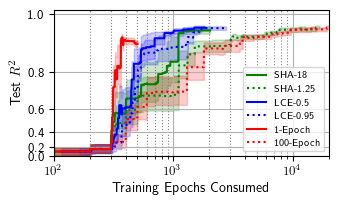

In [111]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

data_y_final = {k: [] for k in data.keys()}

plt.figure(figsize=figsize)

pf_x = []
pf_y = []
y_min_all = 0.0

for i, (stopper, stopper_items) in enumerate(data.items()):
    for j, (stopper_args, dfs) in enumerate(stopper_items.items()):
        print(stopper, stopper_args)
        # color = cmap(i)
        color = map_stopper_to_color.get(stopper, cmap(i))
        linestyle = linestyle_list.get(j, "-")

        x_space = np.arange(max_budget, max_evals * max_budget + 1)
        dfs_processed = map(
            lambda x: process(
                x,
                mode="max",
                topk_tournament=map_stopper_to_topk[stopper],
                max_budget=max_budget,
            ),
            dfs,
        )
        x_max_j = 0
        x_min_j = max_evals * max_budget
        y_list = []
        for j, df in enumerate(dfs_processed):
            x = df["m:budget_cumsum"].to_numpy()
            x_max_j = max(x[-1], x_max_j)
            x_min_j = min(x[0], x_min_j)

            if plot_val:
                y = df.loc[df["max_idx"]]["m:objective_val"].values
            else:
                y = df.loc[df["max_idx"]]["m:objective_test"].values
            f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            # f = interp1d(x, y, kind="previous", bounds_error=False, fill_value=(np.nan, y[-1]))
            y = f(x_space)

            y_list.append(y)

        mask = (x_space >= x_min_j) & (x_space <= x_max_j)
        x = x_space[mask]
        y_list = np.asarray(y_list)
        y_list = y_list[:, mask]
        y_mean = np.mean(y_list, axis=0)
        y_stde = np.std(y_list, axis=0) / np.sqrt(y_list.shape[0])
        y_min = y_mean - y_stde
        y_max = y_mean + y_stde

        y_min_all = min(y_min_all, np.min(y_min))

        data_y_final[stopper].append([x[-1], -y_mean[-1], y_stde[-1]])

        plt.plot(
            x,
            y_mean,
            # linestyle=map_stopper_to_linestyle[stopper],
            linestyle=linestyle,
            color=color,
            label=f"{map_stopper_to_label[stopper].format(stopper_args)}",
        )
        plt.fill_between(
            x,
            y_min,
            y_max,
            alpha=0.2,
            color=color,
        )

plt.xlabel("Training Epochs Consumed")
if plot_val:
    plt.ylabel("Validation $R^2$")
else:
    plt.ylabel("Test $R^2$")
plt.xlim(max_budget, max_budget * max_evals)
plt.ylim(0, 1)
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
# plt.legend(ncol=3, fontsize=7)
plt.legend(ncol=1, fontsize=7, loc="lower right")
# plt.savefig(os.path.join(exp.task, "curves.jpg"), dpi=300, bbox_inches="tight")
plt.xscale("log")

def forward(x):
    x = np.power(10, x)
    return x

def inverse(x):
    x = np.log(x) / np.log(10)
    return x


plt.yscale("function", functions=(forward, inverse))
plt.ylim(y_min_all, 1.01)
ax = plt.gca()
if y_min_all < 0:
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([y_min_all, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([f"{y_min_all:.0e}", "0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]))
else:
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]))
plt.savefig(os.path.join(exp.task, "curves_log.jpg"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(exp.task, "curves_log_all.jpg"), dpi=300, bbox_inches="tight")
plt.show()

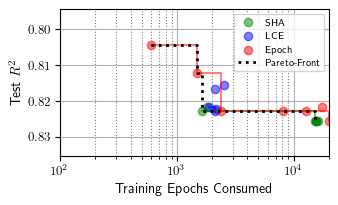

In [105]:
from deephyper.skopt.moo import pareto_front

y_all = []

plt.figure(figsize=figsize)

for i, (stopper, y) in enumerate(data_y_final.items()):
    y = np.array(y)
    y_all.extend(y[:,:2])
    pf, pf_idx = pareto_front(y[:,:2], sort=True, return_idx=True)
    plt.scatter(y[:, 0], -y[:, 1], color=map_stopper_to_color[stopper], label=map_stopper_to_label[stopper].replace("-",""), alpha=0.5)
    plt.step(pf[:, 0], -pf[:, 1], where="post", color=map_stopper_to_color[stopper], alpha=0.5)

y_all = np.array(y_all)
pf = pareto_front(y_all, sort=True)
plt.step(
    pf[:, 0],
    -pf[:, 1],
    color="black",
    linewidth=2,
    linestyle=":",
    where="post",
    label="Pareto-Front",
)

plt.xscale("log")
# def forward(x):
#     x = np.power(10, x)
#     return x

# def inverse(x):
#     x = np.log(x) / np.log(10)
#     return x
# plt.yscale("function", functions=(forward, inverse))

eps = 0.01
plt.ylim(max(-y_all[:, 1]) + eps, np.min(-y_all[:, 1]) - eps)
plt.xlim(max_budget, max_budget * max_evals)
plt.xlabel("Training Epochs Consumed")
if plot_val:
    plt.ylabel("Validation $R^2$")
else:
    plt.ylabel("Test $R^2$")
plt.legend()
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.savefig(os.path.join(exp.task, "pf.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [106]:
exp.task

'densenn/14'